# Law, Bias, and Algorithms
## Narrow Tailoring and Disparate Impact in Law School Admissions
This notebook will provide an example of how machine learning algorithms can be used to select individual applicants out of a pool of candidates based on predicted outcomes. 

This notebook uses the example of law school admissions and considers a scenario where law schools deploy an algorithm to admit students based on the highest predicted bar passage rate. This approach might be motivated from two perspectives. First, perhaps using an outcome-based algorithm would allow schools to lessen the weight on LSAT scores, given the critiques of standardized tests as favoring affluent non-minority groups, and hence constitute a "workable race-neutral alternative." Second, more crudely, one of the major inputs into U.S News and World Report law school rankings is bar passage. Schools might want to admit a class to increase bar passages rates or US News might increase the weight of bar passage in its rankings. Our goal here is to examine whether the adoption of such a policy is a workable alternative and whether it might have disparate impact.

This notebook proceeds by constructing a gradient boosted decision tree model and then applying the model to simulate the admission of law school applicants. It then considers whether there are differences in outcomes between the actual admissions results and the bar-passage optimized admissions results and whether any differences can be deemed algorithmic bias. It also considers some alternative ways to structure an algorithmic model for college admissions and compares the results of those approaches. 

In [52]:
# Some initial setup
options(digits = 3)
library(tidyverse)
library(gbm)
library(zoo)
theme_set(theme_bw())

# Read the data
data <- read_csv("../data/bar_passage_data.csv", col_types = cols())

Each row in the data corresponds to a law school admit. The dataset contains the following variables:

* An ID number:
    * `ID`
    
    
* Base demographic information about the applicant:
    * `MINORITY`, `MALE`
    * `RACE` is encoded as follows:        
        * 0: Non-hispanic White
        * 1: Asian, Black, Hispanic, American Indian, Alaskan Native, or Other
    * `MALE` is coded as 1 for male applicants and 0 for female applicants
        
        
* Outcome of interest, Bar Passage:
    * `PASS_BAR`, `BAR`
    * `PASS_BAR` is an indicator variable and is encoded as 0 regardless of why the student did not pass the exam.  They may have dropped out of law school, never taken the bar, or failed the exam. `PASS_BAR` is encoded as 1 if the student eventually passes the bar. 
    * `BAR` provides more detail about bar results and test history
    
 
* Academic Indicators:
    * `UGPA` (undergraduate GPA), `LSAT` (LSAT score, scaled to be between 10 and 50)
    
    
* Tier of Law School Attended:
    * `TOP_TIER` is an indicator variable for whether an applicant ultmiately attends a top tier school
    * Note that students who attend historically black colleges and universities were removed as those schools are outliers in law school admissions.


* Family Income Quintile:
    * `FAM_INC` provides the family income quintile
    * `FAM_INC_1`, `FAM_INC_2`, `FAM_INC_3`, `FAM_INC_4`,` FAM_INC_5` are indicator variables for the income quintile

Law school admits whose entries had missing data have been removed.

### Exploratory Data Analysis



#### Excercise 1: Initial Data Exploration
Create two tables:
* First, a table showing mean LSAT, undergraduate GPA, and bar passage rates by race and gender
* Second, a table showing the proportion students who are minorities at high and non-high tier law schools

In [90]:
#WRITE CODE HERE

#BEGIN SOLUTION
data %>% 
    group_by(MINORITY,MALE) %>%
    summarize(mean(LSAT),mean(UGPA),mean(PASS_BAR))

data %>% 
    group_by(TOP_TIER) %>%
    summarize(mean(MINORITY))
#END SOLUTION

MINORITY,MALE,mean(LSAT),mean(UGPA),mean(PASS_BAR)
0,0,37.0,3.33,0.825
0,1,37.5,3.20,0.823
1,0,31.4,3.05,0.670
1,1,32.7,2.98,0.653


TOP_TIER,mean(MINORITY)
0,0.118
1,0.149


To visulaize the disributions of the keys variables of interest across race and gender, the following code will create histrograms for LSAT and GPA by race and gender. 

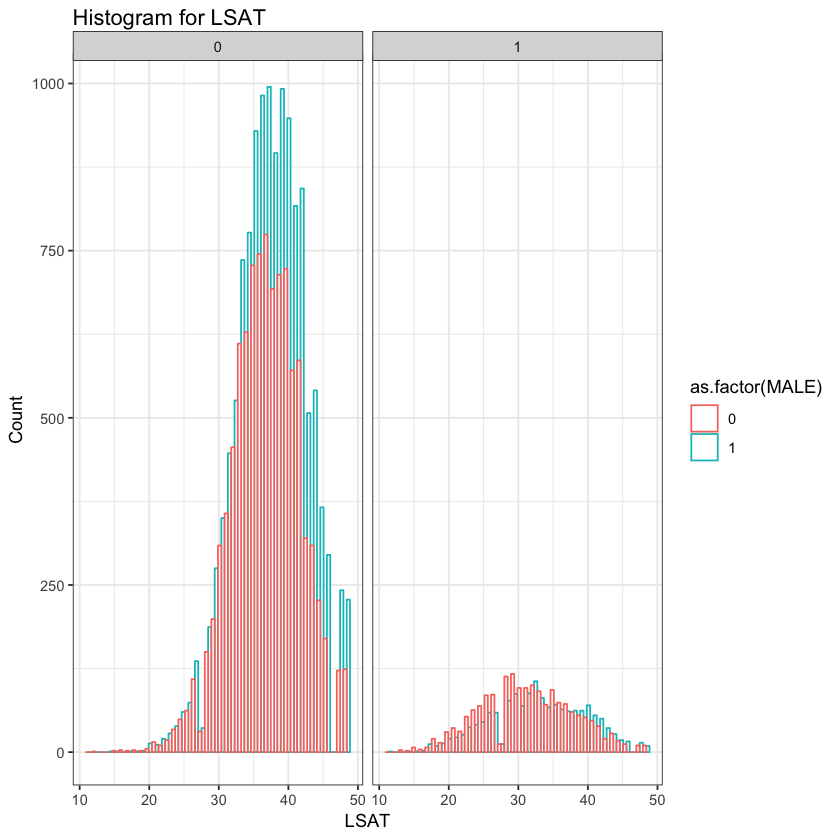

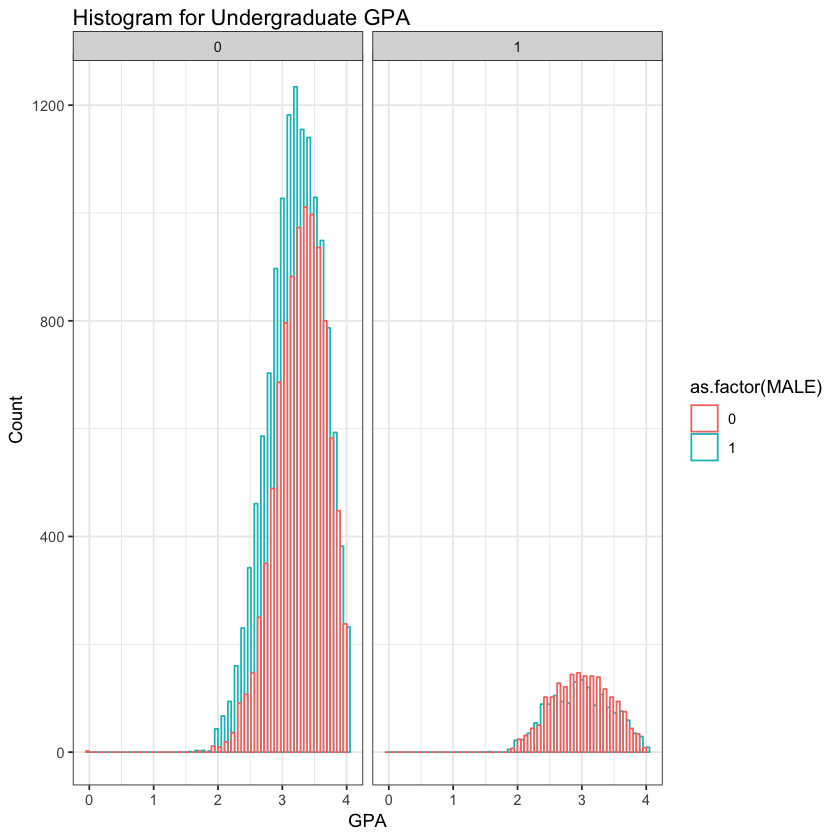

In [92]:
#Histrograms of LSAT and UGPA by Minority Status and Gender
ggplot(data, aes(x = LSAT, color = as.factor(MALE))) + 
    labs(title="Histogram for LSAT", x="LSAT", y="Count") +
    geom_histogram( position="dodge", fill = "white", bins=40) + facet_grid(~MINORITY)
ggplot(data, aes(x = UGPA, color = as.factor(MALE))) + 
    labs(title="Histogram for Undergraduate GPA", x="GPA", y="Count") +
    geom_histogram( position="dodge", bins=40, fill = "white") + facet_grid(~MINORITY)

The majority-minority test gap has been the subject of extensive scientific inquiry. Potential causes may include differences in school resources, poverty, family structure, environment, and discrimination.

### Selecting by UGPA and LSAT Alone

Let's examine what the class profile of admits would look like if law school admissions was only based on the LSAT or alternatively on just undergraduae GPA. 

#### Exercise 2: Simulate an admissions which selects students based just on UGPA and LSAT
Simulate an admissions cycle for top tier law schools assuming students are selected based soly on (1) LSAT or (2) GPA. That is, if $n$ students are admitted to the top tier schools, simulate two admissions cycle where (1) the $n$ students with highest LSAT scores are admitted and (2) where the $n$ students with the highest GPAs are admitted. 

Note that because there is no way to break ties, these models will lead to the admission of more than $n$ studens.

In [115]:
#WRITE CODE HERE

#BEGIN SOLUTION
selected_gpa <- top_n(test, select_count, UGPA) 
rejected_gpa <- test[!(test$ID %in% selected_gpa$ID), ]

selected_LSAT <- top_n(test, select_count, LSAT) 
rejected_LSAT <- test[!(test$ID %in% selected_LSAT$ID), ]
#END Solution

#### Exercise 3: Assess the racial distribution of students admitted under the simulated top ten percent plan

First, calculate the number of minority students admitted to top tier schools in the actual data and compare that to the number of minority students so admitted in the simulated data. This will illustrate how the simulated results compare to actual law school admissions for the period in question, but doesn't nessecarily tell us how to interpret any variation. 

Next, calculate the percent of law school applicants who are minorities. Then calculate what percentage of admitted students are minorities for both the simulated and actual admissions. 

Create a table to store the population level results. Include the following information
    * Number of minority students admitted
    * Percentage of the population which is minority

Create another table to store the the results for each model and the actual results. Include the following information in the table:
    * Model
    * Number of minority students admitted
    * Percentage of admits who are minority



In [119]:
#WRITE CODE HERE

#BEGIN SOLUTION
#Actual Results
actual_selected <- subset(test, TOP_TIER == 1)
actual_minority <- subset(actual_selected, MINORITY == 1)

#Top GPA Results
selected_minority_gpa <- subset(selected_gpa, MINORITY == 1)
rejected_nminority_gpa <- subset(rejected_gpa, MINORITY == 1)
selected_white_gpa <- subset(selected_gpa, MINORITY == 0)

#Top LSAT Results
selected_minority_LSAT <- subset(selected_LSAT, MINORITY == 1)
selected_white_LSAT <- subset(selected_LSAT, MINORITY == 0)

#Determining number of minority students admitted
actual_minority_count <- nrow(actual_minority)
gpa_minority_count <- nrow(selected_minority_gpa)
LSAT_minority_count <- nrow(selected_minority_LSAT)

#Comparing parity of admissions decisions by race
percent_applicant_minority <- (nrow(filter(test, MINORITY == 1)) / nrow(test))
actual_percent_minority <- nrow(actual_minority) / nrow(actual_selected)
gpa_percent_minorty <- nrow(selected_minority_gpa) / nrow(selected_gpa)
LSAT_percent_minorty <- nrow(selected_minority_LSAT) / nrow(selected_LSAT)


population <- data_frame(A = "Full Applicant Population", B = sum(test$MINORITY == 1), C = round(percent_applicant_minority,3))
colnames(population) <- c("","Minority students admitted","Percent of population minority")
model <- c("Actual Results","Top UGPA","Top LSAT")
minority_students_admitted <- c(actual_minority_count, gpa_minority_count, LSAT_minority_count)
percent_minority <- c(actual_percent_minority, gpa_percent_minorty, LSAT_percent_minorty) %>% round(3)
results <- data.frame(model, minority_students_admitted, percent_minority)
colnames(results) <- c("Model","Minority students admitted to top tier school","Percent of admits who are minority")
population
results
#END SOLUTION

,Minority students admitted,Percent of population minority
Full Applicant Population,752,0.124


Model,Minority students admitted to top tier school,Percent of admits who are minority
Actual Results,242,0.150
Top UGPA,147,0.074
Top LSAT,116,0.060


Notice that there are some similarities between the top GPA aproach and a top 10% plan. In a a top ten percent admissions plan works by automatically admitting all students with a GPA in the top 10% of their graduating high school class and then admitting students for remaining spots based on holistic review. The Texas 10% plan led to more diversity in Texas Public Schools because Texas's high schools are highly segregated. Texas adopted a top ten percent admission plan in 1997 for undergraduate admissions in the state. Anti-affirmative action advocates subsequently challenged the top-ten percent plan in the high profile affirmative action lawsuit *Fisher v. Texas* which was the subject of Supreme Court decisions in 2013 and 2016. We aren't able to simulate a top ten percent plan, because our bar passage data lacks region information. Additionally, what regional indicator would you use to implement a Texas-style top ten 10% plan for graduate admissions? 

### Predicting Bar Passage

We would now like to simulate admissions based on predicting which individual law students will pass the bar exam. First we will create a model to predict bar pasage and then we will then use this model to simulate an admissions cycle where the students predicted as being the most likely to pass the bar are admitted into the highest tier law schools. We will first create our predictive model using simple linear regression. (Because we have a binary outcome, technically a logistic regression would be more appropriate here, but we are using a simple linear model for ease of interpretation.) 

FYI in R, the formulas for statistical models use a special formula object which is created with a common syntax. The formula object is written as "dependent variable" ~ "independent variables" with each indepedent variable seperated with the "+" symbol. 


In [120]:
set.seed(12346)

'%!in%' <- function(x,y){
    !('%in%'(x,y))
}

count <- nrow(data)
train_index <- sample(1:count, count*.8, replace = FALSE)
train <- data[data$ID %in% train_index,]
test <- data[data$ID %!in% train_index,]

train.conditioned <- subset(train, train$TOP_TIER == 1)

lm_train <- lm(PASS_BAR ~ LSAT + UGPA + MALE + MINORITY + 
             FAM_INC_2 + FAM_INC_3 + FAM_INC_4 + FAM_INC_5, data = train.conditioned)
summary(lm_train)


Call:
lm(formula = PASS_BAR ~ LSAT + UGPA + MALE + MINORITY + FAM_INC_2 + 
    FAM_INC_3 + FAM_INC_4 + FAM_INC_5, data = train.conditioned)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9803  0.0718  0.1258  0.1807  0.4479 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.28986    0.05945    4.88  1.1e-06 ***
LSAT         0.00976    0.00104    9.40  < 2e-16 ***
UGPA         0.03266    0.01360    2.40   0.0164 *  
MALE        -0.02181    0.00994   -2.20   0.0282 *  
MINORITY    -0.01269    0.01442   -0.88   0.3790    
FAM_INC_2    0.02570    0.03513    0.73   0.4645    
FAM_INC_3    0.05491    0.03270    1.68   0.0932 .  
FAM_INC_4    0.09772    0.03255    3.00   0.0027 ** 
FAM_INC_5    0.08879    0.03503    2.53   0.0113 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.354 on 5264 degrees of freedom
Multiple R-squared:  0.0367,	Adjusted R-squared:  0.0353 
F-statistic: 25.1 on 8 and 5264 DF, 

### Simulating Law School Admissions

We now will use this model to simulate law school admissions on the testing set. In our simulated admissions cycle the top tier law schools will simply accept the same number ($n$) of students as they did in actuality, but will instead simply accept the $n$ students that are the most likely to pass the bar according to our model without considering any other factors. 

#### Exercise 2: Simulate Law School Admissions Based on Predicted Bar Passage
Use the model to predict the likelihood each individual in the test set will pass the bar. Then select the $n$ students with the highest predicted likelihood of passing the bar to be selected into the top tier law schools. These students will be the admitted students in the simulation. 

Store the results of the simulated admissions in two variables as follows:
* `selected` a dataframe of all students selected into a top tier law school in the simulation
* `rejected` a dataframe of all students not selected into a top tier school

In [124]:
# WRITE CODE HERE

# START solution
#Simulate law school admissions based on predicted bar passage
train$pred <- predict(lm_train, train)
test$pred <- predict(lm_train, test)

select_count <- nrow(subset(test, TOP_TIER == 1))
reject_count <- nrow(test) - select_count

selected <- top_n(test, select_count, pred)  
rejected <- top_n(test, -reject_count, pred)  
#END Solution

#### ROC and Calibration Plots

The following code create two additional plots to examine the sensitivity and specificity of the model. These plots also illistrate whether the model is prone to false predictions. 

First, we make an ROC plot, which graphs the true postive rate versus the false positive rate. Each point on the ROC plot shows the sensitivty/specificity of a particular cutoff point for the model. We can also use the area under the ROC cure (AUC) as a measure of the model's overall performance. 

Second, we create a calibration plot. The calibration plot shows the predicted versus the actual result for law school applicants for both above and below the cut point for admission to a top tier school.

[1] "Area Under the Curve:"


[1] 0.647

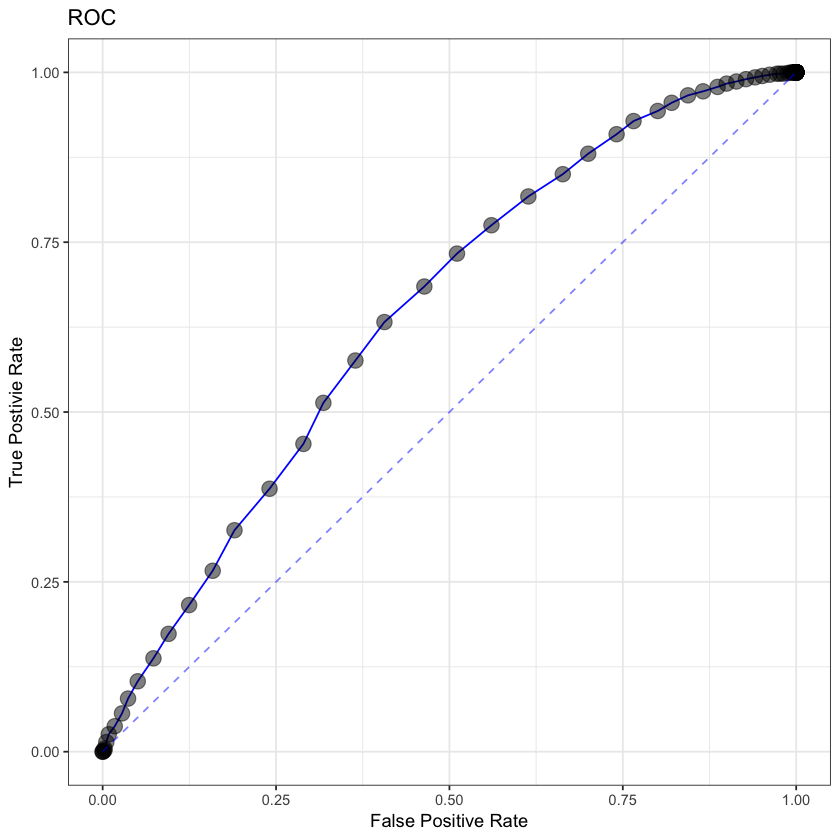

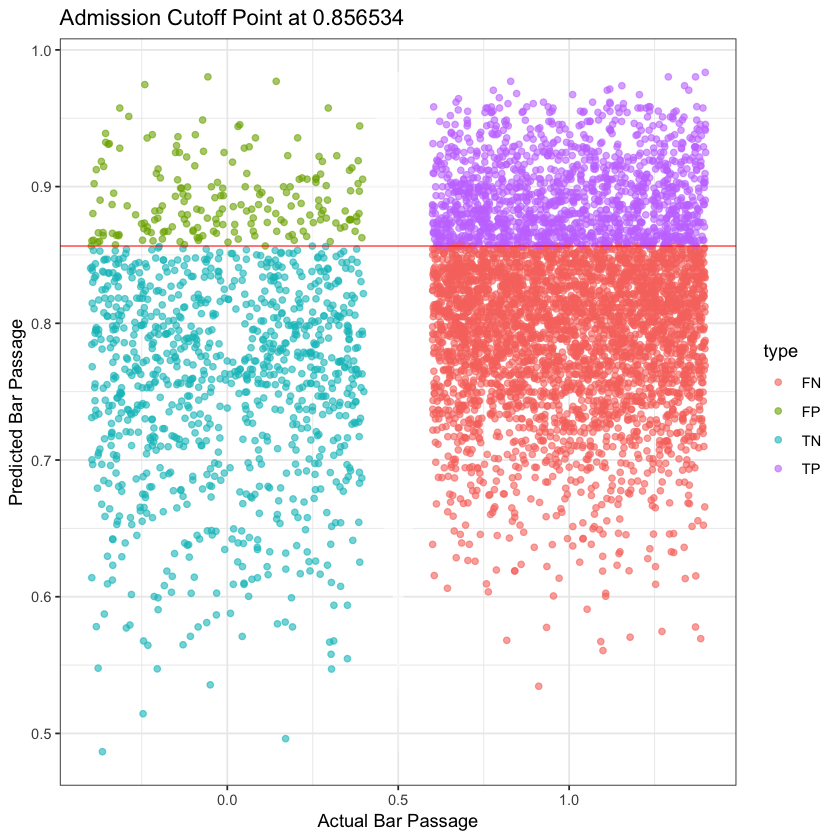

In [125]:
# ROC Plot
plot_df <- data_frame("actual" = test$PASS_BAR, "pred" = test$pred)

calculate_roc <- function(df, n = 101) {
  tpr <- function(df, threshold) {
    sum(df$pred >= threshold & df$actual == 1) / sum(df$actual == 1)
  }
  
  fpr <- function(df, threshold) {
    sum(df$pred >= threshold & df$actual == 0) / sum(df$actual == 0)
  }
    
  roc <- data.frame(threshold = seq(0,1,length.out=n), tpr = NA, fpr = NA)
  roc$tpr <- sapply(roc$threshold, function(th) tpr(df, th))
  roc$fpr <- sapply(roc$threshold, function(th) fpr(df, th))
  
  return(roc)
}

min_pred <- min(selected$pred)                 
                    
roc <- calculate_roc(plot_df)                
cutoff <- min_pred             
hline_val <- roc[roc$threshold == cutoff,]$tpr                    
vline_val <- roc[roc$threshold == cutoff,]$fpr  
                    
roc_plot <- ggplot(roc, aes(fpr,tpr)) + 
    geom_line(color = rgb(0,0,1)) +
    geom_point(size = 4, alpha = 0.5) +
    ggtitle("ROC") + xlab("False Positive Rate") + ylab("True Postivie Rate") +
    geom_line(aes(threshold,threshold), color=rgb(0,0,1,alpha = 0.5),linetype = "dashed") +
    geom_hline(yintercept=hline_val, alpha=0.5, linetype = "dashed") +
    geom_vline(xintercept=vline_val, alpha=0.5, linetype = "dashed")
roc_plot
                    
AUC <- -sum(diff(roc$fpr)*rollmean(roc$tpr,2))
print("Area Under the Curve:")
AUC
                    
# Calibration Plot
calibration_plot <- function(df, threshold) {
  v <- rep(NA, nrow(df))
  v <- ifelse(df$pred >= threshold & df$actual == 1, "TP", v)
  v <- ifelse(df$pred >= threshold & df$actual == 0, "FP", v)
  v <- ifelse(df$pred < threshold & df$actual == 1, "FN", v)
  v <- ifelse(df$pred < threshold & df$actual == 0, "TN", v)
    
  df$pred_type <- v
    
  ggplot(data = df, aes(x = actual, y = pred)) + 
    geom_violin(fill=rgb(1,1,1,alpha = 0.6), color = NA) + 
    geom_jitter(aes(color = pred_type), alpha = 0.6) +
    geom_hline(yintercept = threshold, color = "red", alpha = 0.6) +
    scale_color_discrete(name = "type") +
    xlab("Actual Bar Passage") + ylab("Predicted Bar Passage") +
    labs(title=sprintf("Admission Cutoff Point at %f", threshold))
}

calibration_plot(plot_df, min_pred)

We can also use more complicated models for this task. Here there isn't any reason to use a more complex (and less interpretable) model, but to demonstrate here how "fancy" machine learning algorithms can be implemented we will  create an admissions model using a gradient boosted decision tree.  

Notice that we use the same formula variable in both models! 

In [126]:
gbm_train <- suppressWarnings(gbm(PASS_BAR ~ LSAT + UGPA + MALE + MINORITY + 
             FAM_INC_2 + FAM_INC_3 + FAM_INC_4 + FAM_INC_5, data = train.conditioned,
             distribution = "gaussian", n.trees = 2000,
             shrinkage = 0.005, interaction.depth = 5, cv.folds = 10))

#If you would like to see summary information about the gradient boosted tree you may run the following code
#This code creates the following tables and graphs
# 1. A relative influence table, which gives the relative influence of each variable in the model on the predicted outcome (normalized to sum to one hundred)
# 2. A table describing the first tree in the gradient boosted model. Each row corresponds to a node of the tree. The SplitVar column indicates the dependendent variable the node in question is splitting on starting at 0. A SplitVar of -1 indicates a terminal node.  
# 3. The sqaure error loss plot for the model. This graph shows the loss function (which is what the model is minimizing) as a function of the number of iterations. The final model uses the number of iterations that minimizes the loss function. 
# 4. A plot showing the marginal influence on predicted bar passage of LSAT and UGPA pairing. The other variables are integrated out to create this plot. 
#print(gbm_train)
#summary(gbm_train, plotit = FALSE)
#pretty.gbm.tree(gbm_train, i.tree = 1)
#plot(gbm_train, i.var = c("LSAT","UGPA"))

#### Exercise 2: Simulate Law School Admissions Based on Predicted Bar Passage
Use the gradient boosted decision tree model to simulate another round of law school admissions. As before, select the $n$ students with the highest predicted likelihood of passing the bar to be selected into the top tier law schools.

Store the results of the simulated admissions in two variables as follows:
* `selected_gbm` a dataframe of all students selected into a top tier law school in the simulation
* `rejected_gbm` a dataframe of all students not selected into a top tier school

Using 462 trees...


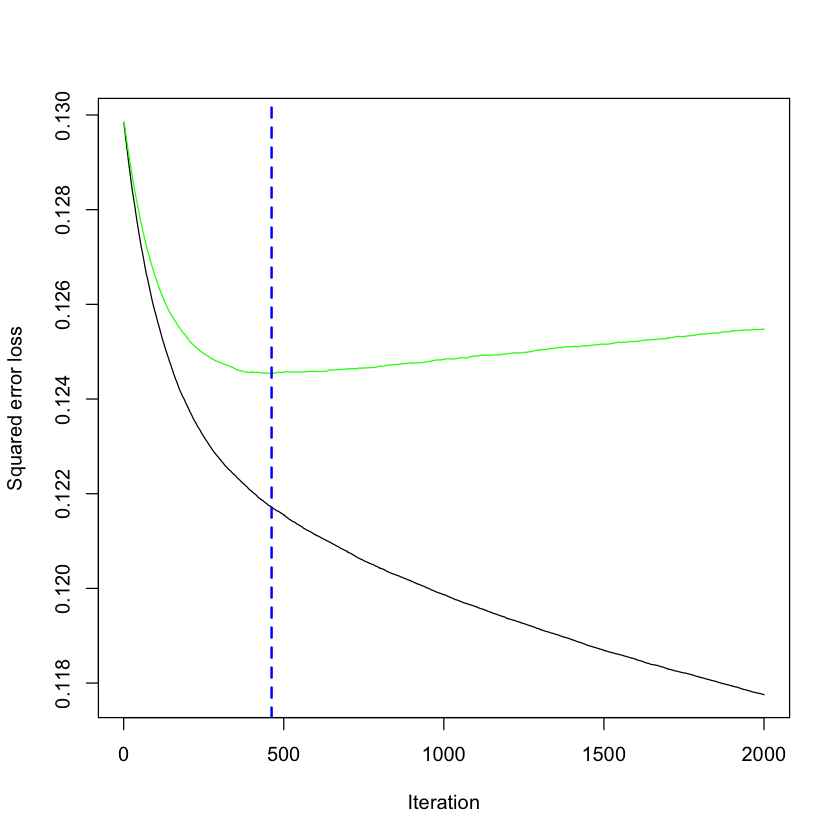

In [127]:
#WRITE CODE HERE

#START SOLUTION
test$pred_gbm <- predict(gbm_train, test)

selected_gbm <- top_n(test, select_count, pred_gbm)  
rejected_gbm <- top_n(test, -reject_count, pred_gbm) 
#END SOLUTION

### Evaluating Disparate Impact

Having simulated admissions to law schools, we now want to check how the number of minority students who would be admitted to top law schools if our model was used compares to how many minority students were actually admitted. 

#### Exercise 3: Comparing Admissions Rates
* Calculate the number of minority students admitted to top tier schools in the actual data and compare that to the number of minority students so admitted in the simulated data. This will illustrate how the simulated results compare to actuanl law school admissions for the period in question, but doesn't nessecarily tell us how to interpret any variation. 
* Next, calculate the percent of law school applicants who are minorities. Then calculate what percentage of admitted students are minorities for both the simulated and actual admissions. 
* Create a table to store the these results for the model, the actual results, and the corresponding numbers for the full population of law school attendees. Include the following information in the table
    * Model
    * Number of Minority Students Admitted
    * Percentage of Minority Students Admitted
* For the full population include the total number of minoirty law school admits and the overall percentage of minorties among all admits. 

* If our model was used, would there be a valid disparate action claim for any applicants who are rejected from top tier schools?

In [134]:
# WRITE CODE HERE

# START solution
selected_minority_lm <- subset(selected, MINORITY == 1)
selected_minority_gbm <- subset(selected_gbm, MINORITY == 1)

#Comparing simulated admissions to actual admissions
lm_minority_count <- nrow(selected_minority_lm)
gbm_minority_count <- nrow(selected_minority_gbm)

#Comparing parity of admissions decisions by race
lm_percent_minorty <- nrow(selected_minority_lm) / nrow(selected)
gbm_percent_minorty <- nrow(selected_minority_gbm) / nrow(selected_gbm)

percent_minority <- c(percent_applicant_minority, actual_percent_minority, gbm_percent_minorty) %>% round(3)

#Putting all the data together into a table
lm_results <- data_frame(A = "Linear Model", B = lm_minority_count, C = round(lm_percent_minorty,3))
colnames(lm_results) <- colnames(results)
gbm_results <- data_frame(A = "Gradient Boosted Tree", B = gbm_minority_count, C = round(gbm_percent_minorty,3))
colnames(gbm_results) <- colnames(results)
results <- rbind(results, lm_results)
results <- rbind(results, gbm_results)
population
results

#END Solution

,Minority students admitted,Percent of population minority
Full Applicant Population,752,0.124


Model,Minority students admitted to top tier school,Percent of admits who are minority
Actual Results,242,0.150
Top UGPA,147,0.074
Top LSAT,116,0.060
Linear Model Simulated Top Tier Admissions,72,0.045
Gradient Boosted Tree Simulated Top Tier Admissions,95,0.059
Linear Model,72,0.045
Gradient Boosted Tree,95,0.059
Linear Model,72,0.045
Gradient Boosted Tree,95,0.059
Linear Model,72,0.045


#### Excercise 4: Evaluate this Model as a Policy Proposal

Consider if an admissions office came to you with the proposal of using this model for dertermining which law students that school would admit. How would you evaluate the model and what would you recomemnd to the admissions office? 

### Modeling Bar Passage Without Race or Gender

#### Exercise 5: Creating a Model for Bar Passage Without Race and Gender

One aspect of the above model that we might be concerned about is the fact that it specifically includes suspect class information, namely race and gender. But does leaving out race and gender impact the results of simulated law school admissions or even make the results potentially more biased?

Consider that if race and gender are left out, the model has less information to train on and we would expect it therefore, all else being equal, to be less accurate than a model with that information. And while the model will no longer explicitly categorize based on race and gender, racial and gender differences may still get picked up by the model through other correlated variables. 

Based on the model above, create a new gradient boosted tree that leaves out the applicants' race and gender. Then simulate law school admissions by selecting the top $n$ students to be admitted to top tier law schools. 

Using 443 trees...


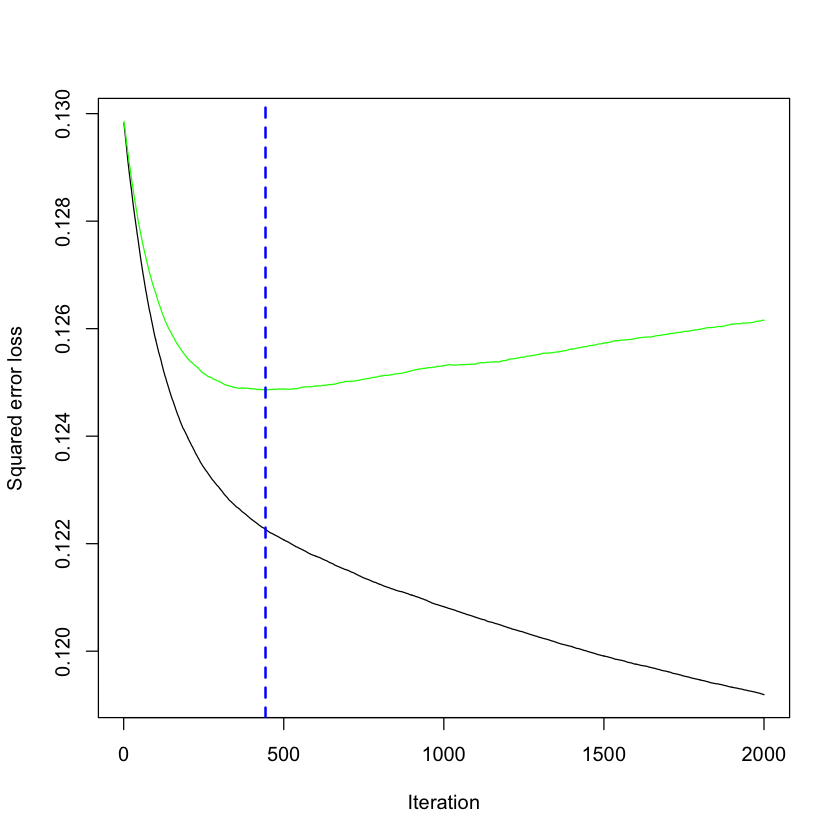

In [135]:
# WRITE CODE HERE

#START Solution
set.seed(12346)
gbm_train_2 <- suppressWarnings(gbm(PASS_BAR ~ LSAT + UGPA + 
             FAM_INC_2 + FAM_INC_3 + FAM_INC_4 + FAM_INC_5, data=train.conditioned,
             distribution = "gaussian", n.trees = 2000,
             shrinkage = 0.005, interaction.depth = 5, cv.folds=10))


test$pred_2 <- predict(gbm_train_2, test)

selected_2 <- top_n(test, select_count, pred_2)  
rejected_2 <- top_n(test, -reject_count, pred_2)
#END Solution

#### Exercise 6: Assess the racial distribution of students admitted under the new model
Use the same measures as above to assess the racial impact of this new model and whether there is evidence of algorithmic bias. Add the results to the results table you created initially for the original model. 

How does this test compare to the previous one? Is your assessment different?

In [140]:
# WRITE CODE HERE

# START solution
selected_minority_2 <- subset(selected_2, MINORITY==1)
rejected_minority_2 <- subset(rejected_2, MINORITY==1)
selected_white_2 <-subset(selected_2, MINORITY==0)

gbm_no_race_gender_minority_count <- nrow(selected_minority_2)
gbm_no_race_gender_percent_minority <- nrow(selected_minority_2) / nrow(selected_2)

no_race_gender <- data_frame(A = "GBTree Without Race or Gender", B = gbm_no_race_gender_minority_count, C = round(gbm_no_race_gender_percent_minority,3))
colnames(no_race_gender) <- colnames(results)
results <- rbind(results, no_race_gender)
population
results

#END Solution

,Minority students admitted,Percent of population minority
Full Applicant Population,752,0.124


Model,Minority students admitted to top tier school,Percent of admits who are minority
Actual Results,242,0.150
Top UGPA,147,0.074
Top LSAT,116,0.060
Linear Model Simulated Top Tier Admissions,72,0.045
Gradient Boosted Tree Simulated Top Tier Admissions,95,0.059
Linear Model,72,0.045
Gradient Boosted Tree,95,0.059
Linear Model,72,0.045
Gradient Boosted Tree,95,0.059
Linear Model,72,0.045


### Discussion Questions

One way to characterize the use of bar passage information is as an attempt to reduce the importance of the LSAT in determining law school admissions. Does using bar passage data fulfill the goal of reducing emphasis on the LSAT?

Consider what some of the potential problems with this data set are. What factors are not represented in the data that might be relevant for predicting outcomes on the bar exam? For success as an attorney? Are their any concerns about state bar passage as an outcome measure? What factors might drive the differences between the different models?  

How well do these models mimic the procedure of the actual admissions process? How does the performance of actual admissions officers compare to the models we have here and to the extent there are differences in outcomes, what factors might drive those differences? 

Are there important differences between the populations of interest that may influence the model in undesirable ways? Consider whether minority students are more likely to practice in jurisdictions with lower bar passage rates (e.g., NY or CA)? Consider whether stereotype threat or implicit bias might explain differences in academic or bar passage performance between white and minority students and what implications that has for the approach you've studied above.